In [0]:
!kill -9 -1

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
!pip3 install torch torchvision
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python


In [0]:
!pip3 install --upgrade pip

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
!cat /proc/meminfo

In [0]:
!cat /proc/cpuinfo

In [6]:
!ls drive/Collab/
import os
os.chdir("drive/Collab")

deep_dream_pytorch  hello_collab.ipynb	mnist_cnn.py


In [0]:
print('Setup complete')

In [7]:
os.chdir("deep_dream_pytorch")
!ls

beagle1.png  beagle.jpg  setup.ipynb


In [8]:
#Begin deep_dream
!pip3 install --no-cache-dir -I pillow
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
from PIL import Image, ImageFilter, ImageChops

import matplotlib.pyplot as plt
%matplotlib inline

    100% |████████████████████████████████| 2.0MB 12.1MB/s 


In [9]:
net = models.vgg16
net = net(pretrained=True).cuda()
print(net)
modulelist = list(net.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
def load_image(path):
  image = Image.open(path)
  plt.imshow(image)
  plt.title("Image loaded successfully")
  return image

preprocess = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
  

In [0]:
def gradient_ascent(image, layer, iterations, lr):
  input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
  net.zero_grad()
  for i in range(iterations):
    out = input
    for j in range(layer):
      out = modulelist[j+1](out)
      loss = out.norm()
      loss.backward(retain_graph=True)
      input.data = input.data + lr * input.grad.data
      
  input = input.data.squeeze()
  input.transpose_(0,1)
  input.transpose_(1,2)
  input = np.clip(deprocess(input),0,1)
  im = Image.fromarray(np.uint8(input*255))
  return im


In [0]:

def octaves(image, layer, iterations, lr, octave_scale, num_octaves):
  if num_octaves>0:
    image1 = image.filter(ImageFilter.GaussianBlur(2))
    if (image1.size[0]/octave_scale<1 or image1.size[1]/octave_scale<1):
      size = image1.size
    else:
      size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
    
    image1 =  image1.resize(size, Image.ANTIALIAS)
    image1 = octaves(image1, layer, iterations, lr, octave_scale, num_octaves-1)
    size = (image.size[0], image.size[1])
    image1 = image1.resize(size, Image.ANTIALIAS)
    image = ImageChops.blend(image, image1, 0.6)
    print("---Octave Level : {} ---".format(num_octaves))
  img_result = gradient_ascent(image, layer, iterations, lr)
  img_result.resize(image.size)
  plt.imshow(img_result)
  return img_result

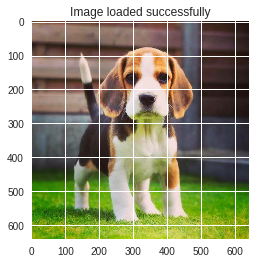

In [13]:
me = load_image("beagle.jpg")

---Octave Level : 1 ---
---Octave Level : 2 ---


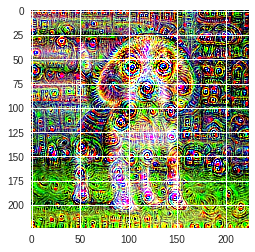

In [22]:
me_28_2o = octaves(me, 28, 5, 0.001, 4, 2)

---Octave Level : 1 ---
---Octave Level : 2 ---
---Octave Level : 3 ---
---Octave Level : 4 ---
---Octave Level : 5 ---
---Octave Level : 6 ---
---Octave Level : 7 ---
---Octave Level : 8 ---
---Octave Level : 9 ---
---Octave Level : 10 ---
---Octave Level : 11 ---
---Octave Level : 12 ---
---Octave Level : 13 ---
---Octave Level : 14 ---
---Octave Level : 15 ---
---Octave Level : 16 ---
---Octave Level : 17 ---
---Octave Level : 18 ---
---Octave Level : 19 ---
---Octave Level : 20 ---


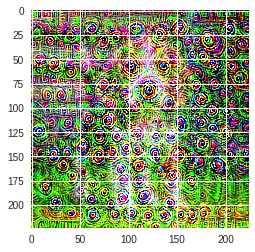

In [17]:
me_28 = octaves(me, 28, 5, 0.001, 4, 20)

---Octave Level : 1 ---
---Octave Level : 2 ---
---Octave Level : 3 ---
---Octave Level : 4 ---
---Octave Level : 5 ---
---Octave Level : 6 ---
---Octave Level : 7 ---
---Octave Level : 8 ---
---Octave Level : 9 ---
---Octave Level : 10 ---
---Octave Level : 11 ---
---Octave Level : 12 ---
---Octave Level : 13 ---
---Octave Level : 14 ---
---Octave Level : 15 ---
---Octave Level : 16 ---
---Octave Level : 17 ---
---Octave Level : 18 ---
---Octave Level : 19 ---
---Octave Level : 20 ---


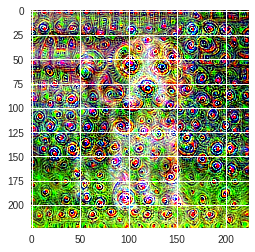

In [19]:
me_24 = octaves(me, 24, 5, 0.001, 4, 20)

---Octave Level : 1 ---


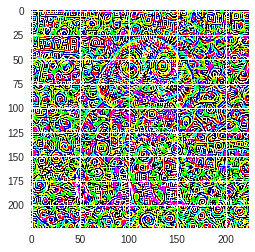

In [14]:
me_5 = octaves(me, 28, 9, 0.01, 4, 1)

In [0]:
me_24.save('layer24.jpg')
me_5.save('layer5.jpg')
me_28.save('layer28_20octaves.jpg')
me_28_2o.save('layer28_2octaves.jpg')
del me_24
del me_5
del me_28
del me_28_2o

---Octave Level : 1 ---
---Octave Level : 2 ---
---Octave Level : 3 ---
---Octave Level : 4 ---
---Octave Level : 5 ---
---Octave Level : 6 ---


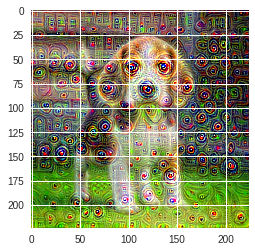

In [29]:
me_24_4 = octaves(me, 24, 10, 0.0001, 4, 6)

---Octave Level : 1 ---
---Octave Level : 2 ---
---Octave Level : 3 ---
---Octave Level : 4 ---
---Octave Level : 5 ---
---Octave Level : 6 ---


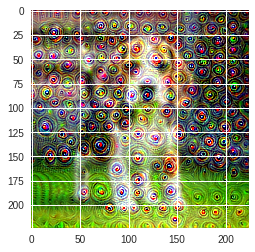

In [28]:
me_24 = octaves(me, 24, 10, 0.0001, 2, 6)

---Octave Level : 1 ---
---Octave Level : 2 ---
---Octave Level : 3 ---
---Octave Level : 4 ---
---Octave Level : 5 ---
---Octave Level : 6 ---


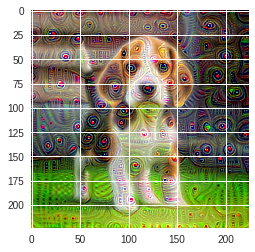

In [30]:
me_24_1 = octaves(me, 19, 10, 0.0001, 2, 6)

---Octave Level : 1 ---
---Octave Level : 2 ---
---Octave Level : 3 ---


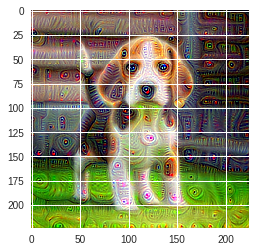

In [31]:
me_24_1 = octaves(me, 19, 10, 0.0001, 2, 3)